In [0]:
#參考網站 https://blog.csdn.net/qq_24330285/article/details/80453264
#資料網址 https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [64]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [65]:
ls! "/content/drive/My Drive/Colab Notebooks/tmdb_5000_movies.csv"

ls: cannot access '!': No such file or directory
'/content/drive/My Drive/Colab Notebooks/tmdb_5000_movies.csv'


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [0]:
#导入数据
movies=pd.read_csv('/content/drive/My Drive/Colab Notebooks/tmdb_5000_movies.csv')
credit=pd.read_csv('/content/drive/My Drive/Colab Notebooks/tmdb_5000_credits.csv')

In [68]:
#检查两个id列和title列是否真的相同
(movies['id']==credit['movie_id']).describe()

count     4803
unique       1
top       True
freq      4803
dtype: object

In [69]:
(movies['title']==credit['title']).describe()

count     4803
unique       1
top       True
freq      4803
Name: title, dtype: object

In [0]:
#删除多余列
del credit['movie_id']
del credit['title']
del movies['homepage']
del movies['spoken_languages']
del movies['original_language']
del movies['original_title']
del movies['overview']
del movies['tagline']
del movies['status']


In [0]:
#合并两个数据集
full_df=pd.concat([credit,movies],axis=1)#横向连接

In [72]:
#缺失值处理，首先找到缺失值,然后对其进行处理
nan_x=full_df['runtime'].isnull()
full_df.loc[nan_x,:]

,cast,crew,budget,genres,id,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
2656,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de...",15000000,"[{""id"": 18, ""name"": ""Drama""}]",370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,"[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de...",2,"[{""id"": 99, ""name"": ""Documentary""}]",459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,"To Be Frank, Sinatra at 100",0.0,0


In [0]:
#在网上查询对应的信息，并填进去
full_df.loc[2656,'runtime']=98
full_df.loc[4140,'runtime']=82

In [74]:
#release_date字段的缺失值同样处理
nan_y=full_df['release_date'].isnull()
full_df.loc[nan_y,:]

,cast,crew,budget,genres,id,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
4553,[],[],0,[],380097,[],0.0,[],[],NaN,0,0.0,America Is Still the Place,0.0,0


In [0]:
#同样在网上找到对应的信息，并填进去
full_df.loc[4553,'release_date']='2014-06-01'

In [76]:
#将release_date的类型转换成日期类型
full_df['release_date']=pd.to_datetime(full_df['release_date'],errors='coerce',format='%Y-%m-%d')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 15 columns):
cast                    4803 non-null object
crew                    4803 non-null object
budget                  4803 non-null int64
genres                  4803 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4803 non-null datetime64[ns]
revenue                 4803 non-null int64
runtime                 4803 non-null float64
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(7)
memory usage: 562.9+ KB


In [77]:
#转换成日期格式后，提取对应的年份
full_df['release_year']=full_df['release_date'].map(lambda x : x.year)
full_df.loc[:,'release_year'].head()

0    2009
1    2007
2    2015
3    2012
4    2012
Name: release_year, dtype: int64

In [0]:
#提取json格式
#使用json.loads将json格式转化成字符串
json_cols=['genres','keywords','production_companies','production_countries','cast','crew']
for i in json_cols:
    full_df[i]=full_df[i].apply(json.loads)
#用join方法将所有类型汇总
def get_names(x):
    return ','.join(i['name'] for i in x)

full_df['genres']=full_df['genres'].apply(get_names)
full_df['keywords']=full_df['keywords'].apply(get_names)
full_df['production_companies']=full_df['production_companies'].apply(get_names)
full_df['production_countries']=full_df['production_countries'].apply(get_names)


In [79]:
full_df['genres'].head()

0    Action,Adventure,Fantasy,Science Fiction
1                    Adventure,Fantasy,Action
2                      Action,Adventure,Crime
3                 Action,Crime,Drama,Thriller
4            Action,Adventure,Science Fiction
Name: genres, dtype: object

In [80]:
#电影类型随时间变化
#获取所有电影类型
real_genres=set()
for i in full_df['genres'].str.split(','):
    real_genres=real_genres.union(i)
real_genres=list(real_genres)#将集合转换成列表
real_genres.remove('')#删除空格
print(real_genres)


['Documentary', 'Romance', 'Foreign', 'Adventure', 'Fantasy', 'Animation', 'Music', 'Crime', 'Horror', 'History', 'Thriller', 'TV Movie', 'Mystery', 'Comedy', 'War', 'Family', 'Drama', 'Western', 'Action', 'Science Fiction']


In [81]:
#将所有类型添加到列表
for i in real_genres:
    full_df[i]=full_df['genres'].str.contains(i).apply(lambda x:1 if x else 0)
full_df.head(2)

,cast,crew,budget,genres,id,keywords,popularity,production_companies,production_countries,release_date,...,Thriller,TV Movie,Mystery,Comedy,War,Family,Drama,Western,Action,Science Fiction
0,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"Action,Adventure,Fantasy,Science Fiction",19995,"culture clash,future,space war,space colony,so...",150.437577,"Ingenious Film Partners,Twentieth Century Fox ...","United States of America,United Kingdom",2009-12-10,...,0,0,0,0,0,0,0,0,1,1
1,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"Adventure,Fantasy,Action",285,"ocean,drug abuse,exotic island,east india trad...",139.082615,"Walt Disney Pictures,Jerry Bruckheimer Films,S...",United States of America,2007-05-19,...,0,0,0,0,0,0,0,0,1,0


In [82]:
#获取年份和类型子集
part1_df=full_df[['release_year', 'Family', 'War', 'Documentary', 'Mystery', 'Foreign','Science Fiction', 'History', 'Adventure', 'Music', 'Animation',
       'Western', 'Action', 'Crime', 'Comedy', 'Drama', 'Romance', 'Horror','Thriller', 'Fantasy', 'TV Movie']]
#按年分组统计每年各类型电影数量
year_cnt=part1_df.groupby('release_year').sum()
year_cnt.tail()


,Family,War,Documentary,Mystery,Foreign,Science Fiction,History,Adventure,Music,Animation,Western,Action,Crime,Comedy,Drama,Romance,Horror,Thriller,Fantasy,TV Movie
release_year,,,,,,,,,,,,,,,,,,,,
2013,22,3,10,5,0,27,8,36,12,17,1,56,37,71,110,25,25,53,21,2
2014,23,10,7,15,0,26,7,37,9,14,3,54,27,62,110,24,21,66,16,0
2015,17,2,7,20,0,28,9,35,8,13,7,46,26,52,95,23,33,67,10,0
2016,9,3,0,6,0,11,6,23,1,4,1,39,10,26,37,9,20,27,13,0
2017,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


Text(0.5,1,'每年电影类型数量')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


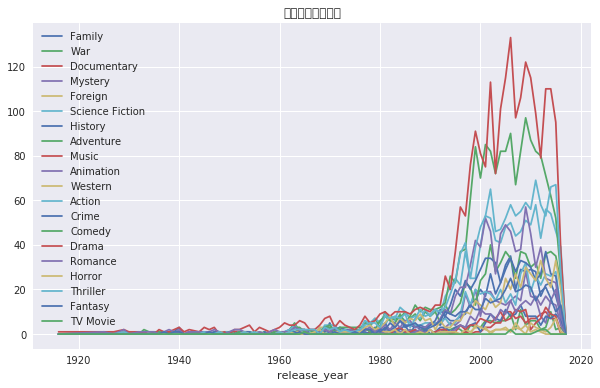

In [83]:
#绘图
plt.figure(figsize=(10,6))
plt.rc('font',family='SimHei',size=10)#设置字体和大小，否则中文无法显示
ax1=plt.subplot(1,1,1)
year_cnt.plot(kind='line',ax=ax1)
plt.title('每年电影类型数量')


In [84]:
#不同电影类型总数量
genre=year_cnt.sum(axis=0)#对列求和
genre=genre.sort_values(ascending=True)
genre

TV Movie              8
Foreign              34
Western              82
Documentary         110
War                 144
Music               185
History             197
Animation           234
Mystery             348
Fantasy             424
Family              513
Horror              519
Science Fiction     535
Crime               696
Adventure           790
Romance             894
Action             1154
Thriller           1274
Comedy             1722
Drama              2297
dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['STXihei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


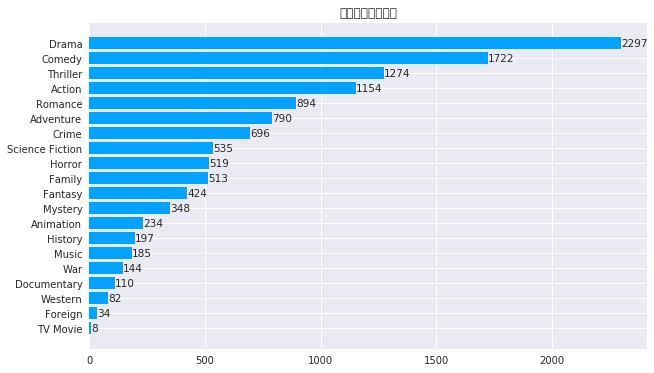

In [85]:
#对上面的数据绘制横向条形图
plt.figure(figsize=(10,6))
plt.rc('font',family='STXihei',size=10.5)
ax2=plt.subplot(1,1,1)
label=list(genre.index)
data=genre.values
rect=ax2.barh(range(len(label)),data,color='#03A2FF',alpha=1)
ax2.set_title('不同电影类型数量')#设置标题
ax2.set_yticks(range(len(label)))
ax2.set_yticklabels(label)
#添加数据标签
for x,y in zip(data,range(len(label))):
    ax2.text(x,y,'{}'.format(x),ha='left',va='center')


In [86]:
#计算不同类型电影收入(亿元)
r={}
for i in real_genres:
    r[i]=full_df.loc[full_df[i]==1,'revenue'].sum(axis=0)/100000000
revenue=pd.Series(r).sort_values(ascending=True)
revenue


TV Movie              0.000000
Foreign               0.123982
Documentary          10.822777
Western              37.921691
Music                89.643511
History             113.321417
War                 121.184459
Horror              225.998947
Mystery             272.487228
Crime               460.408607
Animation           528.121679
Romance             536.421375
Science Fiction     815.642357
Fantasy             819.821999
Family              832.832387
Thriller           1032.504263
Drama              1197.109840
Comedy             1227.605176
Action             1629.599145
Adventure          1648.415616
dtype: float64

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Simhei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


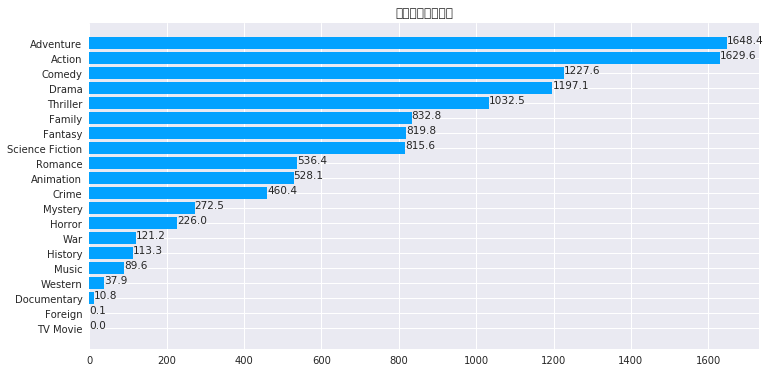

In [87]:
#对上面的结果绘制横向条形图
plt.figure(figsize=(12,6))
plt.rc('font',family='Simhei',size=10.5)
ax=plt.subplot(1,1,1)
label=revenue.index
data=revenue.values
ax.barh(range(len(label)),data,color='#03A2FF',alpha=1)
ax.set_yticks(range(len(label)))#设置y轴刻度
ax.set_yticklabels(label)#设置刻度名称
ax.set_title('不同类型电影收入')
#添加数据标签
for x,y in zip(data,range(len(label))):
    ax.text(x,y,'{:.1f}'.format(x))#坐标位置，及要显示的文字内容


In [88]:
#票房收入影响因素分析
corr=full_df.corr()#计算各变量间的相关系数矩阵
corr_revenue=corr['revenue'].sort_values(ascending=False)#提取收入与其他变量间的相关系数，并从大到小排序
corr_revenue.head(10)


revenue         1.000000
vote_count      0.781487
budget          0.730823
popularity      0.644724
Adventure       0.344400
runtime         0.251201
Fantasy         0.212287
Action          0.203590
Animation       0.199335
vote_average    0.197150
Name: revenue, dtype: float64

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


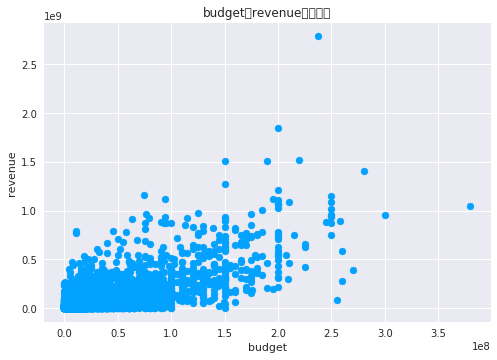

In [89]:
#可以看到，在电影上映前，不会有vote_count, popularity 的数据，因此可以看到相关性最高的就是budget预算（成本）
#绘制散点图，分析budget与revenue的相关性
x=full_df.loc[:,'budget']
y=full_df.loc[:,'revenue']
plt.rc('font',family='SimHei',size=10.5)
plt.scatter(x,y,color='#03A2FF')
plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('budget与revenue的散点图')
plt.show()


In [90]:
#原创电影与改编电影分析
part2_df=full_df.loc[:,['release_year','keywords']]
part2_df['based_on_novel']=part2_df['keywords'].str.contains('based on novel').apply(lambda x:1 if x else 0)  
part2_df['not_based_on_novel']=part2_df['keywords'].str.contains('based on novel').apply(lambda x:0 if x else 1)  
part2_df.head()


,release_year,keywords,based_on_novel,not_based_on_novel
0,2009,"culture clash,future,space war,space colony,so...",0,1
1,2007,"ocean,drug abuse,exotic island,east india trad...",0,1
2,2015,"spy,based on novel,secret agent,sequel,mi6,bri...",1,0
3,2012,"dc comics,crime fighter,terrorist,secret ident...",0,1
4,2012,"based on novel,mars,medallion,space travel,pri...",1,0


In [91]:
novel_per_year=part2_df.groupby('release_year')['based_on_novel','not_based_on_novel'].sum(axis=0)
novel_per_year.tail()

,based_on_novel,not_based_on_novel
release_year,,
2013,9,222
2014,14,225
2015,12,204
2016,12,92
2017,0,1


Text(0.5,1,'原创电影与改编电影数量趋势图')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


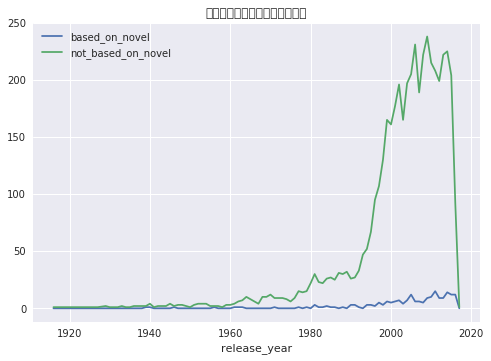

In [92]:
#对上面结果绘制折线图
novel_per_year.plot()
plt.rc('font',family='SimHei',size=10.5)
plt.title('原创电影与改编电影数量趋势图')

In [93]:
#原创电影与改编电影总数
novel_all=[part2_df['based_on_novel'].sum(axis=0),part2_df['not_based_on_novel'].sum(axis=0)]
novel_rate=novel_all/sum(novel_all)
novel_rate


array([0.04101603, 0.95898397])

Text(0.5,1,'原创电影与改编电影数量占比')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


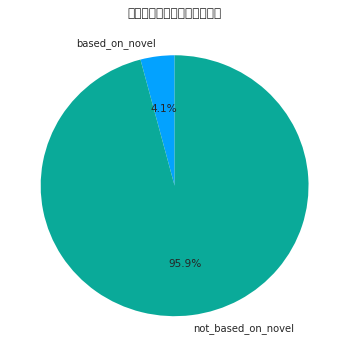

In [94]:
#对上面结果绘制饼图
plt.figure(figsize=(6,6))
plt.rc('font',family='SimHei',size=10.5)
ax=plt.subplot(111)#与plt.sumplot(1,1,1)效果一样
labels=['based_on_novel','not_based_on_novel']
colors=['#03A2FF','#0AAA99']
ax.pie(novel_rate,labels=labels,colors=colors,startangle=90,autopct='%1.1f%%')
ax.set_title('原创电影与改编电影数量占比')


In [95]:
#统计各个国家的电影数
part3_df=full_df[['production_countries','id','release_year']]#提取需要的列子集
#由于有的电影产地属于多个国家，故需要对production_countries进行分列
split_df=pd.DataFrame([x.split(',') for x in part3_df['production_countries']],index=part3_df.index)
#将分列后的数据集与源数据集合并
part3_df=pd.merge(part3_df,split_df,left_index=True,right_index=True)
#下面代码实现列转行
st_df=part3_df[['release_year',0,1,2,3]]
st_df=st_df.set_index('release_year')
st_df=st_df.stack()
st_df=st_df.reset_index()

st_df=st_df.rename(columns={0:'production_countries'})#对列重命名
countries=st_df['production_countries'].value_counts()#统计各个国家的电影数
countries.sum()
countries_rate=countries/countries.sum()#计算占比
countries_top5=countries_rate.head(5)
other={'other':1-countries_top5.sum()}
countries_top6=countries_top5.append(pd.Series(other))
countries_top6


United States of America    0.600244
United Kingdom              0.095978
Germany                     0.048751
France                      0.046466
Canada                      0.039610
other                       0.168952
dtype: float64

Text(0.5,1,'电影产地分布')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


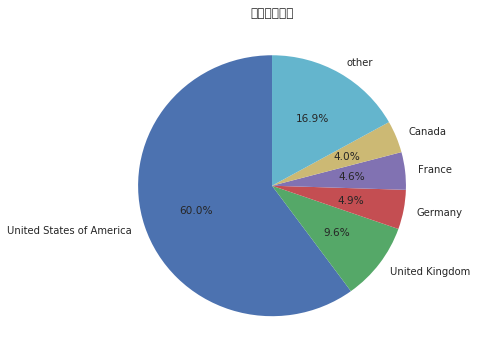

In [96]:
#对上面结果绘制饼图
labels=list(countries_top6.index)
plt.figure(figsize=(6,6))
plt.rc('font',family='SimHei',size=10.5)
ax=plt.subplot(1,1,1)
ax.pie(countries_top6,labels=labels,startangle=90,autopct='%1.1f%%')
ax.set_title('电影产地分布')


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


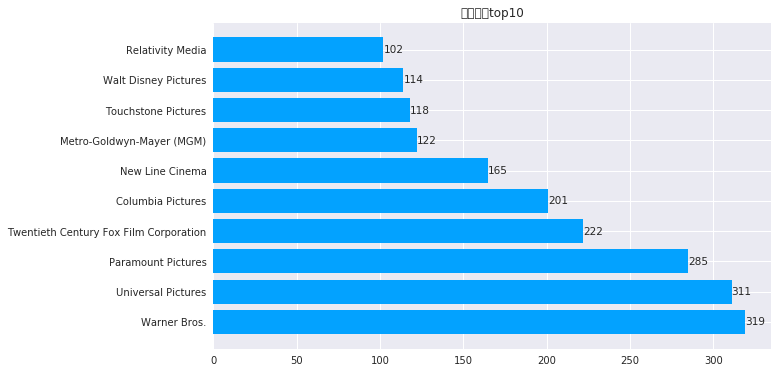

In [97]:
#统计各个电影公司电影数
part4_df=full_df[['production_companies','release_year']]
split_df=pd.DataFrame([x.split(',') for x in part4_df['production_companies']],index=part4_df.index)
part4_df=pd.merge(part4_df,split_df,left_index=True,right_index=True)
del part4_df['production_companies']
part4_df=part4_df.set_index('release_year')
part4_df=part4_df.stack()
part4_df=part4_df.reset_index()
part4_df=part4_df.rename(columns={0:'production_companies'})
companies=part4_df['production_companies'].value_counts()
companies_top10=companies[companies.index!=''].head(10)
#绘制横向条形图
plt.figure(figsize=(10,6))
plt.rc('font',family='SimHei',size=10.5)
ax=plt.subplot(111)
ax.barh(range(10),companies_top10.values,color='#03A2FF')
ax.set_title('电影公司top10')
ax.set_yticks(range(10))
ax.set_yticklabels(companies_top10.index)
for x,y in zip(companies_top10.values,range(10)):
    ax.text(x,y,'{}'.format(x),ha='left',va='center')
